# FALTA CORRER EL NOTEBOOK DE VUELTA, YA SELECCIONE QUE GUARDE UN MODELO CON 50 N ESTIMATORS

# Random Forest por Píxel para Clasificación de Cultivos

En este notebook desarrollaremos un modelo de Random Forest por píxel utilizando los datos generados por el script 9 (`9_NDVI_con_recortes.tif`). Este raster contiene:

- **Banda 1**: Categorías de invierno (INTA)
- **Banda 2**: Categorías de verano (INTA)
- **Bandas 3+**: Estadísticas NDVI temporales (mediana, mínimo, máximo, desviación estándar) y series temporales de NDVI

El objetivo es entrenar un clasificador que pueda predecir las categorías de cultivos a partir de las características espectrales y fenológicas derivadas del NDVI.

## Consideraciones Espaciales

Es fundamental tener en cuenta que cuando trabajamos con datos espaciales, los píxeles vecinos suelen estar correlacionados espacialmente. Si entrenamos con píxeles que son vecinos de los píxeles de test, el modelo puede "hacer trampa" al aprender patrones espaciales locales en lugar de patrones generalizables.

Para manejar esta complicación típica de los modelos espaciales, implementaremos métodos modernos de validación espacial que aseguren que:

1. Los píxeles de entrenamiento no sean vecinos espaciales de los píxeles de test
2. Se mantenga la independencia espacial entre los conjuntos de entrenamiento y validación
3. Las métricas de evaluación reflejen la capacidad real de generalización del modelo


In [9]:
import numpy as np
import pandas as pd
import rasterio
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import os

# ============================================================================
# CONFIGURACION DE PATHS
# ============================================================================

# Directorio base del proyecto (el notebook está en scripts/, subimos un nivel)
PROJECT_ROOT = os.path.join("..")
DATA_PROC_DIR = os.path.join(PROJECT_ROOT, "data", "proc")

# Archivo de entrada generado por el script 9
RASTER_PATH = os.path.join(DATA_PROC_DIR, "11_NDVI_inta_verano.tif")

# Convertir a ruta absoluta para verificación
RASTER_PATH_ABS = os.path.abspath(RASTER_PATH)

print(f"Raster de entrada (relativo): {RASTER_PATH}")
print(f"Raster de entrada (absoluto): {RASTER_PATH_ABS}")
print(f"Archivo existe: {os.path.exists(RASTER_PATH)}")

Raster de entrada (relativo): ..\data\proc\11_NDVI_inta_verano.tif
Raster de entrada (absoluto): e:\ade_modelo_agricola\data\proc\11_NDVI_inta_verano.tif
Archivo existe: True


## Agrupación de Categorías

En el notebook del EDA inicial vimos que nos conviene entrenar un modelo para invierno y otro para verano. Arranco con el de verano. Las categorías del INTA eran un tanto heterogéneas, así que voy a agruparlas en tres clases principales:

- **CULTIVO AGRÍCOLA**: Maíz (10), Soja (11), Girasol (12), Sorgo (18), Papa (26)
- **BARBECHO**: Barbecho (21)
- **NO AGRÍCOLA**: No agrícola (22) y 255 (nodata/máscara)

Esta agrupación simplifica el problema de clasificación y agrupa cultivos con características fenológicas similares.

## Decisiones de Modelado

### 1. Variables Predictoras (Features)

Utilizaremos las siguientes bandas del raster `11_NDVI_inta_verano.tif`:
- **Bandas 2-5**: Estadísticas NDVI (mediana, mínimo, máximo, desviación estándar) calculadas sobre los meses desde diciembre 2023
- **Bandas 6-12**: Series temporales NDVI (7 meses: dic-2023 a jun-2024)

**Total: 11 features** que capturan tanto la variabilidad temporal como las estadísticas resumen del NDVI.

### 2. Variable Objetivo

Clasificación multiclase en 3 categorías:
- **0**: CULTIVO AGRÍCOLA
- **1**: BARBECHO  
- **2**: NO AGRÍCOLA

### 3. Validación Espacial

Para evitar la autocorrelación espacial, implementaremos una estrategia de **validación por bloques espaciales**:

- Dividiremos el área en bloques espaciales (grid)
- Los bloques de entrenamiento y test estarán separados espacialmente
- Esto asegura que píxeles vecinos no estén en conjuntos diferentes
- Usaremos un 70% para entrenamiento y 30% para test, manteniendo la proporción de clases (stratified)

### 4. Algoritmo: Random Forest

**Hiperparámetros seleccionados**:
- `n_estimators`: Se optimizará mediante análisis de OOB error (rango 10-200)
- `max_depth=20`: Limita la profundidad de los árboles para evitar sobreajuste, permitiendo capturar patrones complejos sin memorizar los datos
- `min_samples_split=5`: Evita sobreajuste en hojas pequeñas
- `min_samples_leaf=2`: Controla la complejidad de los nodos terminales
- `class_weight='balanced'`: Maneja desbalance de clases automáticamente
- `oob_score=True`: Habilita cálculo de Out-of-Bag error para validación sin conjunto de test separado
- `random_state=42`: Reproducibilidad

**Justificación**: Random Forest es robusto para datos espaciales, maneja bien features no lineales, y proporciona importancia de variables.


In [16]:
# Cargar datos del raster
print("=" * 80)
print("CARGANDO DATOS")
print("=" * 80)

with rasterio.open(RASTER_PATH) as src:
    # Leer banda 1: categorías INTA verano
    categorias_inta = src.read(1)
    
    # Leer bandas 2-12: features (estadísticas + series temporales)
    features_list = []
    for i in range(2, 13):
        banda = src.read(i).astype(np.float32)
        if src.nodata is not None:
            banda[banda == src.nodata] = np.nan
        features_list.append(banda)
    
    # Apilar features: shape (11, height, width)
    X_all = np.stack(features_list, axis=0)
    
    # Obtener metadata
    height, width = categorias_inta.shape
    transform = src.transform
    crs = src.crs
    
    print(f"\nDimensiones del raster: {height} x {width}")
    print(f"Numero de features: {X_all.shape[0]}")
    print(f"CRS: {crs}")

# Reshape para tener (n_pixels, n_features)
n_pixels = height * width
X_all = X_all.reshape(X_all.shape[0], -1).T  # Shape: (n_pixels, n_features)
categorias_inta_flat = categorias_inta.flatten()

print(f"\nTotal de píxeles: {n_pixels:,}")
print(f"Shape de X: {X_all.shape}")
print(f"Shape de y: {categorias_inta_flat.shape}")

# Definir mapeo de categorías
# CULTIVO AGRÍCOLA: 10 (Maíz), 11 (Soja), 12 (Girasol), 18 (Sorgo), 26 (Papa)
# BARBECHO: 21
# NO AGRÍCOLA: 22 (No agrícola), 255 (nodata)

cultivos_agricolas = [10, 11, 12, 18, 26]
barbecho = [21]
no_agricola = [22, 255]

# Crear variable objetivo agrupada
y_agrupado = np.full_like(categorias_inta_flat, -1, dtype=np.int32)

for cat_val in cultivos_agricolas:
    y_agrupado[categorias_inta_flat == cat_val] = 0  # CULTIVO AGRÍCOLA

y_agrupado[categorias_inta_flat == 21] = 1  # BARBECHO

for cat_val in no_agricola:
    y_agrupado[categorias_inta_flat == cat_val] = 2  # NO AGRÍCOLA

# Filtrar píxeles válidos (excluir -1 que son categorías no mapeadas)
mask_valido = y_agrupado >= 0
X_valido = X_all[mask_valido]
y_valido = y_agrupado[mask_valido]

# También filtrar píxeles con NaN en features
mask_sin_nan = ~np.any(np.isnan(X_valido), axis=1)
X_clean = X_valido[mask_sin_nan]
y_clean = y_valido[mask_sin_nan]

print(f"\nPíxeles válidos (con categoría mapeada): {len(X_valido):,}")
print(f"Píxeles válidos (sin NaN en features): {len(X_clean):,}")

# Estadísticas de clases
clases, conteos = np.unique(y_clean, return_counts=True)
nombres_clases = ['CULTIVO AGRÍCOLA', 'BARBECHO', 'NO AGRÍCOLA']

print(f"\nDistribución de clases:")
for clase, conteo, nombre in zip(clases, conteos, nombres_clases):
    porcentaje = 100 * conteo / len(y_clean)
    print(f"  {nombre} (clase {clase}): {conteo:,} píxeles ({porcentaje:.2f}%)")


CARGANDO DATOS

Dimensiones del raster: 2897 x 2798
Numero de features: 11
CRS: EPSG:32721

Total de píxeles: 8,105,806
Shape de X: (8105806, 11)
Shape de y: (8105806,)

Píxeles válidos (con categoría mapeada): 8,105,806
Píxeles válidos (sin NaN en features): 8,104,712

Distribución de clases:
  CULTIVO AGRÍCOLA (clase 0): 4,486,080 píxeles (55.35%)
  BARBECHO (clase 1): 1,134,418 píxeles (14.00%)
  NO AGRÍCOLA (clase 2): 2,484,214 píxeles (30.65%)


In [17]:
# Validación espacial por bloques
print("=" * 80)
print("PREPARANDO VALIDACION ESPACIAL")
print("=" * 80)

# Recuperar coordenadas espaciales de los píxeles válidos
# Necesitamos los índices (fila, columna) de los píxeles válidos
indices_validos = np.where(mask_valido)[0]
indices_clean = indices_validos[mask_sin_nan]

# Convertir índices lineales a coordenadas (fila, columna)
filas = indices_clean // width
columnas = indices_clean % width

print(f"Píxeles con coordenadas: {len(filas):,}")

# Crear grilla de bloques espaciales
# Dividir en bloques de aproximadamente igual tamaño
n_bloques_filas = 3
n_bloques_cols = 3
n_bloques_total = n_bloques_filas * n_bloques_cols

# Calcular tamaño de cada bloque
tam_bloque_fila = height // n_bloques_filas
tam_bloque_col = width // n_bloques_cols

print(f"\nConfiguración de bloques:")
print(f"  Bloques: {n_bloques_filas} x {n_bloques_cols} = {n_bloques_total}")
print(f"  Tamaño bloque: ~{tam_bloque_fila} x {tam_bloque_col} píxeles")

# Asignar cada píxel a un bloque
bloque_fila = filas // tam_bloque_fila
bloque_col = columnas // tam_bloque_col
# Limitar a rango válido
bloque_fila = np.clip(bloque_fila, 0, n_bloques_filas - 1)
bloque_col = np.clip(bloque_col, 0, n_bloques_cols - 1)
bloque_id = bloque_fila * n_bloques_cols + bloque_col

# Estrategia: asignar bloques alternados a train/test
# Crear máscara de patrones (como tablero de ajedrez)
bloque_fila_idx = bloque_id // n_bloques_cols
bloque_col_idx = bloque_id % n_bloques_cols
# Patrón alternado: suma par = train, impar = test
es_train = (bloque_fila_idx + bloque_col_idx) % 2 == 0

train_indices = np.where(es_train)[0]
test_indices = np.where(~es_train)[0]

print(f"\nDivisión espacial:")
print(f"  Píxeles entrenamiento: {len(train_indices):,} ({100*len(train_indices)/len(bloque_id):.1f}%)")
print(f"  Píxeles test: {len(test_indices):,} ({100*len(test_indices)/len(bloque_id):.1f}%)")

# Verificar distribución de clases en cada conjunto
print(f"\nDistribución de clases - ENTRENAMIENTO:")
y_train = y_clean[train_indices]
clases_train, conteos_train = np.unique(y_train, return_counts=True)
for clase, conteo in zip(clases_train, conteos_train):
    porcentaje = 100 * conteo / len(y_train)
    print(f"  {nombres_clases[clase]}: {conteo:,} ({porcentaje:.2f}%)")

print(f"\nDistribución de clases - TEST:")
y_test = y_clean[test_indices]
clases_test, conteos_test = np.unique(y_test, return_counts=True)
for clase, conteo in zip(clases_test, conteos_test):
    porcentaje = 100 * conteo / len(y_test)
    print(f"  {nombres_clases[clase]}: {conteo:,} ({porcentaje:.2f}%)")

# Preparar conjuntos finales
X_train = X_clean[train_indices]
X_test = X_clean[test_indices]
y_train = y_clean[train_indices]
y_test = y_clean[test_indices]

print(f"\n[OK] Conjuntos de datos preparados para validación espacial")


PREPARANDO VALIDACION ESPACIAL
Píxeles con coordenadas: 8,104,712

Configuración de bloques:
  Bloques: 3 x 3 = 9
  Tamaño bloque: ~965 x 932 píxeles

División espacial:
  Píxeles entrenamiento: 4,503,913 (55.6%)
  Píxeles test: 3,600,799 (44.4%)

Distribución de clases - ENTRENAMIENTO:
  CULTIVO AGRÍCOLA: 2,374,424 (52.72%)
  BARBECHO: 610,004 (13.54%)
  NO AGRÍCOLA: 1,519,485 (33.74%)

Distribución de clases - TEST:
  CULTIVO AGRÍCOLA: 2,111,656 (58.64%)
  BARBECHO: 524,414 (14.56%)
  NO AGRÍCOLA: 964,729 (26.79%)

[OK] Conjuntos de datos preparados para validación espacial


VISUALIZACION DE BLOQUES ESPACIALES


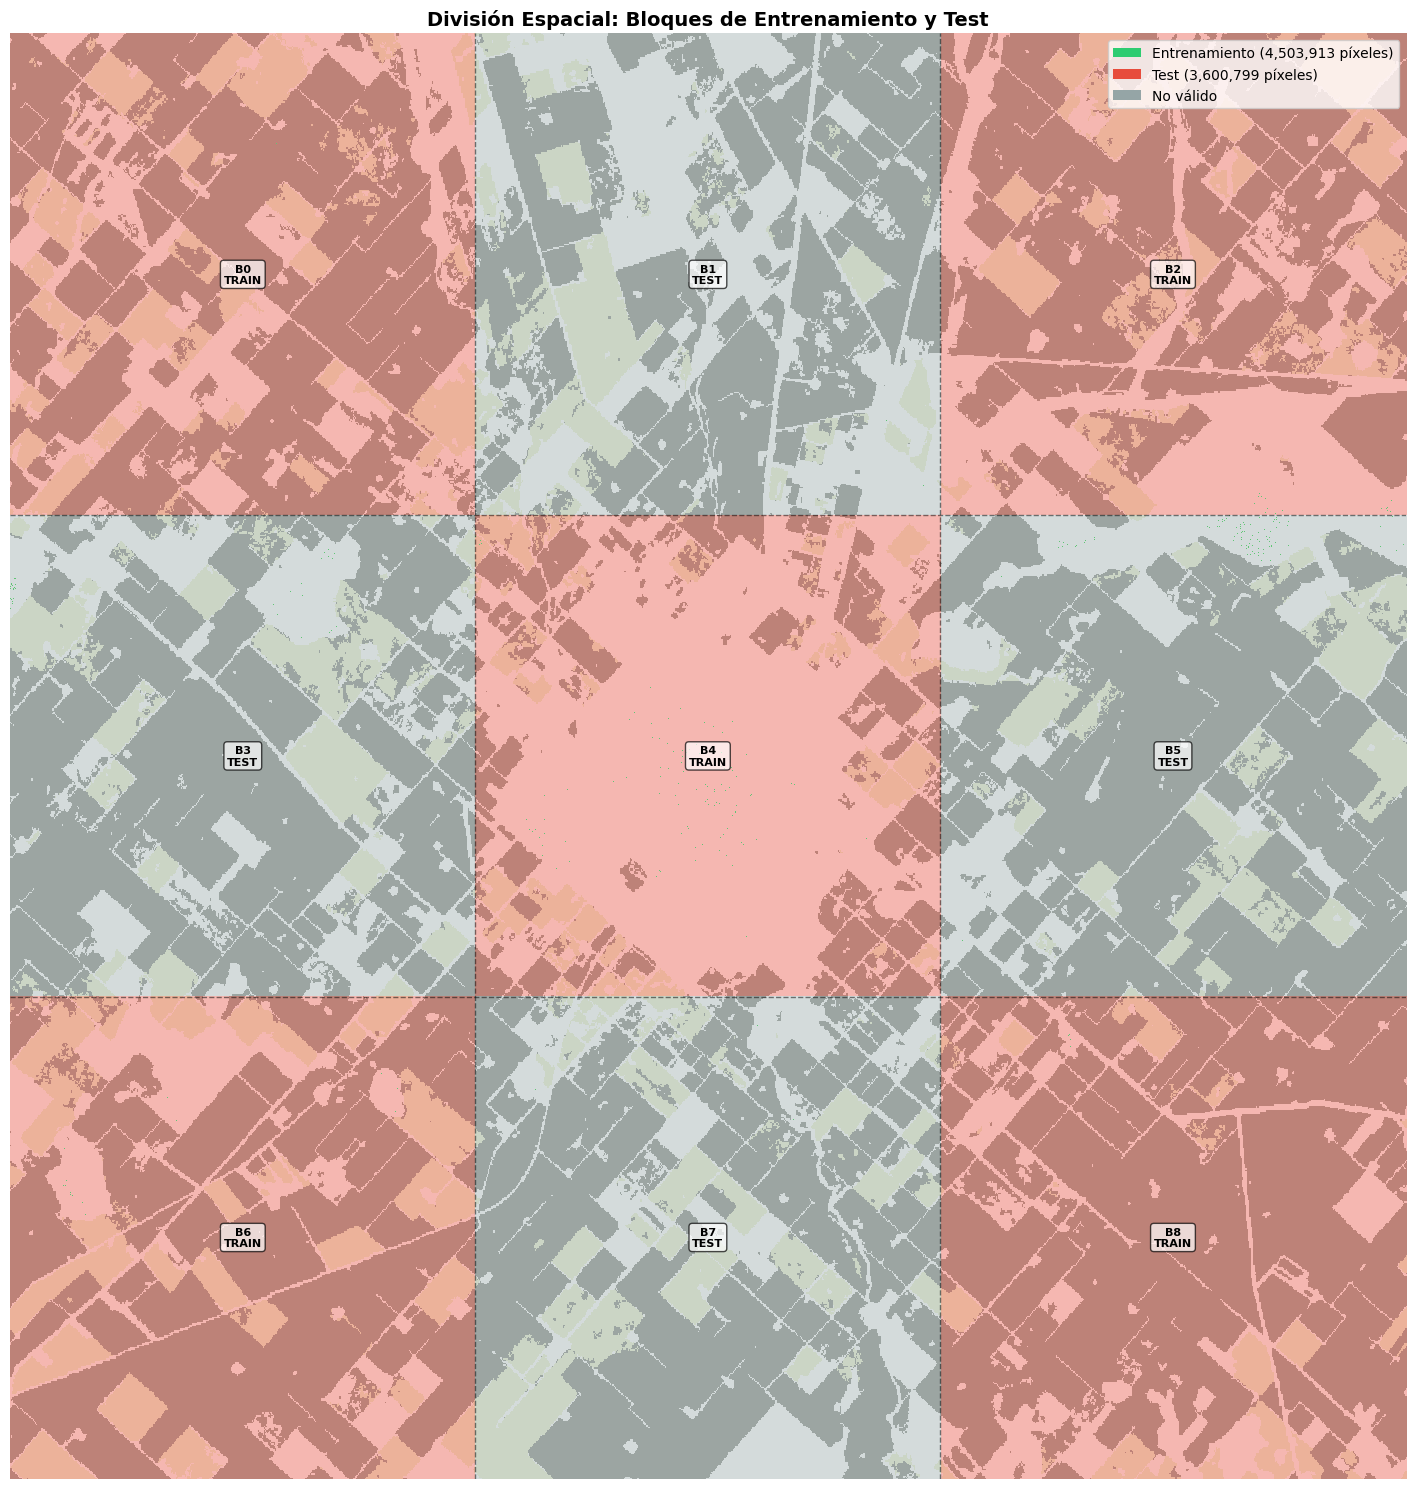


[OK] Visualización de bloques espaciales generada


In [15]:
# Visualizar división espacial de bloques
print("=" * 80)
print("VISUALIZACION DE BLOQUES ESPACIALES")
print("=" * 80)

# Crear mapa de división train/test
mapa_division = np.full((height, width), -1, dtype=np.int32)  # -1 = no válido

# Asignar valores: 0 = train, 1 = test
mapa_division.flat[indices_clean[train_indices]] = 0
mapa_division.flat[indices_clean[test_indices]] = 1

# Crear mapa de fondo con categorías reales para contexto
mapa_fondo = np.full((height, width), -1, dtype=np.int32)
mapa_fondo.flat[indices_clean] = y_clean

# Crear visualización
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Primero mostrar el fondo con las categorías reales
colores_categorias = {
    0: '#339820',  # Verde para CULTIVO AGRÍCOLA
    1: '#646b63',  # Gris para BARBECHO
    2: '#e6f0c2'   # Beige para NO AGRÍCOLA
}
from matplotlib.colors import ListedColormap
cmap_fondo = ListedColormap([colores_categorias[0], colores_categorias[1], colores_categorias[2], '#ffffff'])
ax.imshow(mapa_fondo, cmap=cmap_fondo, vmin=-1, vmax=2, interpolation='nearest', alpha=0.6)

# Luego mostrar la división con transparencia
colores_division = ['#2ecc71', '#e74c3c', '#95a5a6']  # Verde, Rojo, Gris
cmap_division = ListedColormap(colores_division)
im = ax.imshow(mapa_division, cmap=cmap_division, vmin=-1, vmax=1, interpolation='nearest', alpha=0.4)
ax.set_title('División Espacial: Bloques de Entrenamiento y Test', fontsize=14, fontweight='bold')
ax.axis('off')

# Agregar leyenda
from matplotlib.patches import Patch
handles_division = [
    Patch(facecolor=colores_division[0], label=f'Entrenamiento ({len(train_indices):,} píxeles)'),
    Patch(facecolor=colores_division[1], label=f'Test ({len(test_indices):,} píxeles)'),
    Patch(facecolor=colores_division[2], label='No válido')
]
ax.legend(handles=handles_division, loc='upper right', fontsize=10)

# Agregar líneas de división de bloques
for i in range(1, n_bloques_filas):
    y_line = i * tam_bloque_fila
    ax.axhline(y=y_line, color='black', linestyle='--', linewidth=1, alpha=0.5)

for j in range(1, n_bloques_cols):
    x_line = j * tam_bloque_col
    ax.axvline(x=x_line, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Agregar etiquetas de bloques
for bloque_id_num in range(n_bloques_total):
    bloque_fila_idx = bloque_id_num // n_bloques_cols
    bloque_col_idx = bloque_id_num % n_bloques_cols
    
    # Calcular centro del bloque
    centro_y = (bloque_fila_idx + 0.5) * tam_bloque_fila
    centro_x = (bloque_col_idx + 0.5) * tam_bloque_col
    
    # Determinar si es train o test
    es_train_bloque = (bloque_fila_idx + bloque_col_idx) % 2 == 0
    tipo = "TRAIN" if es_train_bloque else "TEST"
    
    # Agregar texto
    ax.text(centro_x, centro_y, f'B{bloque_id_num}\n{tipo}', 
           ha='center', va='center', fontsize=8, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n[OK] Visualización de bloques espaciales generada")


## Entrenamiento del Modelo


ANALISIS DE OOB ERROR vs n_estimators

Evaluando 20 valores de n_estimators...
Rango: 10 a 200 (paso 10)


Entrenando modelos:   0%|          | 0/20 [00:00<?, ?it/s]e:\ade_modelo_agricola\venv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
Entrenando modelos:   5%|▌         | 1/20 [00:46<14:34, 46.03s/it]

  n_estimators= 10: OOB error=0.0955 | Tiempo=46.0s | ETA=14.6 min


e:\ade_modelo_agricola\venv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
Entrenando modelos:  10%|█         | 2/20 [02:10<20:37, 68.74s/it]

  n_estimators= 20: OOB error=0.0864 | Tiempo=84.6s | ETA=19.6 min


e:\ade_modelo_agricola\venv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
Entrenando modelos:  15%|█▌        | 3/20 [04:14<26:36, 93.92s/it]

  n_estimators= 30: OOB error=0.0850 | Tiempo=123.9s | ETA=24.0 min


Entrenando modelos:  20%|██        | 4/20 [07:02<32:51, 123.21s/it]

  n_estimators= 40: OOB error=0.0844 | Tiempo=168.1s | ETA=28.2 min


Entrenando modelos:  25%|██▌       | 5/20 [10:25<38:01, 152.07s/it]

  n_estimators= 50: OOB error=0.0840 | Tiempo=203.3s | ETA=31.3 min


Entrenando modelos:  30%|███       | 6/20 [14:15<41:38, 178.48s/it]

  n_estimators= 60: OOB error=0.0837 | Tiempo=229.7s | ETA=33.3 min


Entrenando modelos:  35%|███▌      | 7/20 [18:49<45:25, 209.62s/it]

  n_estimators= 70: OOB error=0.0835 | Tiempo=273.7s | ETA=35.0 min


Entrenando modelos:  40%|████      | 8/20 [24:08<48:52, 244.37s/it]

  n_estimators= 80: OOB error=0.0835 | Tiempo=318.8s | ETA=36.2 min


Entrenando modelos:  45%|████▌     | 9/20 [29:57<50:49, 277.19s/it]

  n_estimators= 90: OOB error=0.0834 | Tiempo=349.4s | ETA=36.6 min


Entrenando modelos:  50%|█████     | 10/20 [36:30<52:08, 312.89s/it]

  n_estimators=100: OOB error=0.0833 | Tiempo=392.8s | ETA=36.5 min


Entrenando modelos:  55%|█████▌    | 11/20 [43:44<52:30, 350.03s/it]

  n_estimators=110: OOB error=0.0832 | Tiempo=434.2s | ETA=35.8 min


Entrenando modelos:  60%|██████    | 12/20 [51:22<51:02, 382.76s/it]

  n_estimators=120: OOB error=0.0831 | Tiempo=457.6s | ETA=34.2 min


Entrenando modelos:  65%|██████▌   | 13/20 [59:41<48:46, 418.07s/it]

  n_estimators=130: OOB error=0.0831 | Tiempo=499.3s | ETA=32.1 min


Entrenando modelos:  70%|███████   | 14/20 [1:08:39<45:26, 454.42s/it]

  n_estimators=140: OOB error=0.0830 | Tiempo=538.4s | ETA=29.4 min


Entrenando modelos:  75%|███████▌  | 15/20 [1:18:17<40:57, 491.50s/it]

  n_estimators=150: OOB error=0.0830 | Tiempo=577.4s | ETA=26.1 min


Entrenando modelos:  80%|████████  | 16/20 [1:28:34<35:17, 529.34s/it]

  n_estimators=160: OOB error=0.0830 | Tiempo=617.2s | ETA=22.1 min


Entrenando modelos:  85%|████████▌ | 17/20 [1:39:30<28:21, 567.29s/it]

  n_estimators=170: OOB error=0.0829 | Tiempo=655.6s | ETA=17.6 min


Entrenando modelos:  90%|█████████ | 18/20 [1:51:01<20:08, 604.43s/it]

  n_estimators=180: OOB error=0.0829 | Tiempo=690.9s | ETA=12.3 min


Entrenando modelos:  95%|█████████▌| 19/20 [2:03:03<10:40, 640.03s/it]

  n_estimators=190: OOB error=0.0828 | Tiempo=723.0s | ETA=6.5 min


Entrenando modelos: 100%|██████████| 20/20 [2:15:48<00:00, 407.43s/it]

  n_estimators=200: OOB error=0.0828 | Tiempo=764.6s | ETA=0.0 min

[OK] Análisis completado en 135.8 minutos

Generando gráfico de OOB error...


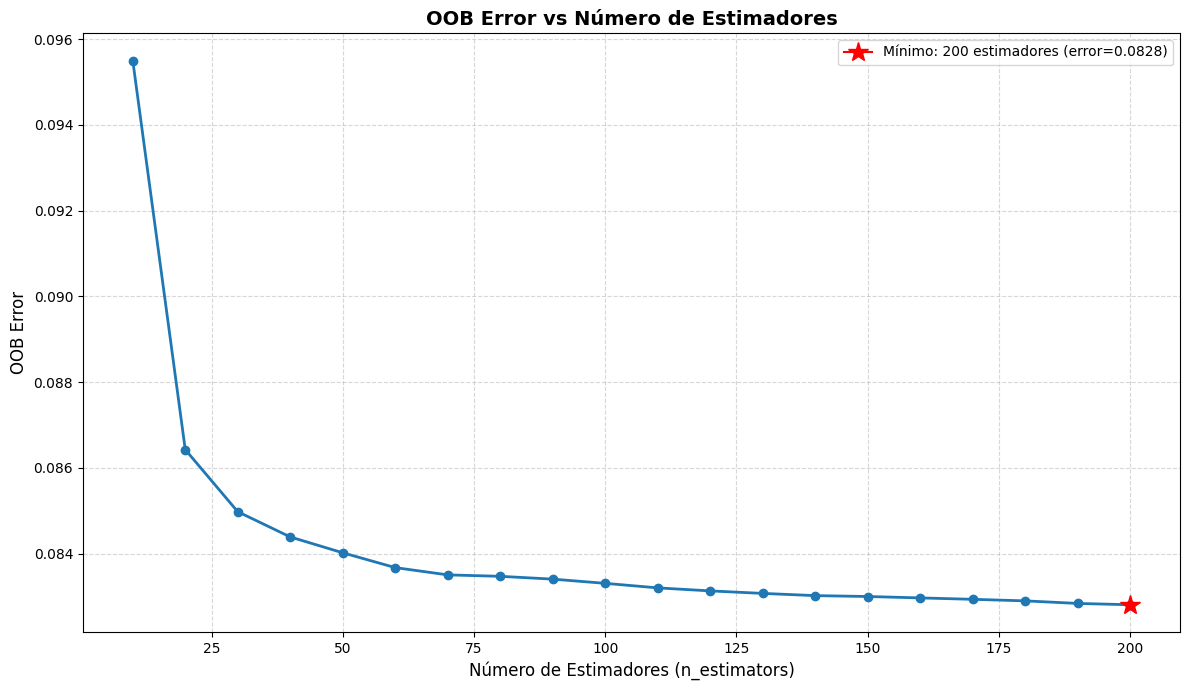


OOB Error mínimo: 0.0828 con 200 estimadores
OOB Error final (200 estimadores): 0.0828

Número óptimo de estimadores seleccionado: 200
  (Error se estabiliza después de 200 estimadores)

ENTRENANDO MODELO FINAL

Entrenando modelo final con n_estimators=200...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 11.4min finished



[OK] Modelo final entrenado en 766.9 segundos
OOB Score del modelo final: 0.9172

Importancia de features (top 5):
  1. NDVI_sd: 0.1505
  2. NDVI_2023-12: 0.1403
  3. NDVI_2024-03: 0.1318
  4. NDVI_2024-02: 0.1295
  5. NDVI_min: 0.1086


In [ ]:
# Análisis de OOB Error vs n_estimators
print("=" * 80)
print("ANALISIS DE OOB ERROR vs n_estimators")
print("=" * 80)

import time
from tqdm import tqdm

# Rango de n_estimators a evaluar
n_estimators_range = range(10, 201, 10)  # 10, 20, 30, ..., 200
oob_errors = []
tiempos_entrenamiento = []

print(f"\nEvaluando {len(n_estimators_range)} valores de n_estimators...")
print(f"Rango: {min(n_estimators_range)} a {max(n_estimators_range)} (paso 10)")

tiempo_inicio_total = time.time()

for n_est in tqdm(n_estimators_range, desc="Entrenando modelos"):
    tiempo_inicio = time.time()
    
    # Entrenar modelo con OOB score habilitado
    rf_temp = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        oob_score=True,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    rf_temp.fit(X_train, y_train)
    
    # Calcular OOB error (1 - OOB score)
    oob_error = 1 - rf_temp.oob_score_
    oob_errors.append(oob_error)
    
    tiempo_entrenamiento = time.time() - tiempo_inicio
    tiempos_entrenamiento.append(tiempo_entrenamiento)
    
    # Calcular ETA
    tiempo_transcurrido = time.time() - tiempo_inicio_total
    modelos_completados = len(oob_errors)
    modelos_restantes = len(n_estimators_range) - modelos_completados
    
    if modelos_completados > 0:
        tiempo_promedio = tiempo_transcurrido / modelos_completados
        eta_segundos = tiempo_promedio * modelos_restantes
        eta_minutos = eta_segundos / 60
        
        print(f"  n_estimators={n_est:3d}: OOB error={oob_error:.4f} | "
              f"Tiempo={tiempo_entrenamiento:.1f}s | ETA={eta_minutos:.1f} min")

tiempo_total = time.time() - tiempo_inicio_total
print(f"\n[OK] Análisis completado en {tiempo_total/60:.1f} minutos")

# Graficar OOB error vs n_estimators
print("\nGenerando gráfico de OOB error...")
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

ax.plot(list(n_estimators_range), oob_errors, marker='o', linewidth=2, markersize=6)
ax.set_xlabel('Número de Estimadores (n_estimators)', fontsize=12)
ax.set_ylabel('OOB Error', fontsize=12)
ax.set_title('OOB Error vs Número de Estimadores', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.5)

# Marcar el mínimo
min_error_idx = np.argmin(oob_errors)
min_n_est = list(n_estimators_range)[min_error_idx]
min_error = oob_errors[min_error_idx]
ax.plot(min_n_est, min_error, marker='*', markersize=15, color='red', label=f'Mínimo: {min_n_est} estimadores (error={min_error:.4f})')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nOOB Error mínimo: {min_error:.4f} con {min_n_est} estimadores")
print(f"OOB Error final (200 estimadores): {oob_errors[-1]:.4f}")

# Seleccionar n_estimators óptimo (donde el error se estabiliza)
# Buscar el punto donde el error no mejora significativamente
umbral_mejora = 0.001  # Mejora mínima para considerar significativa
n_estimators_optimo = min_n_est

# Buscar desde el mínimo hacia adelante donde el error se estabiliza
for i in range(min_error_idx, len(oob_errors)-1):
    mejora = oob_errors[i] - oob_errors[i+1]
    if mejora < umbral_mejora:
        n_estimators_optimo = list(n_estimators_range)[i+1]
        break

print(f"\nNúmero óptimo de estimadores seleccionado: {n_estimators_optimo}")
print(f"  (Error se estabiliza después de {min_n_est} estimadores)")

# Entrenar y guardar modelo con 50 estimadores
print("\n" + "=" * 80)
print("ENTRENANDO Y GUARDANDO MODELO CON 50 ESTIMADORES")
print("=" * 80)

n_estimators_50 = 50
print(f"\nEntrenando modelo con n_estimators={n_estimators_50}...")
tiempo_inicio_50 = time.time()

rf_model_50 = RandomForestClassifier(
    n_estimators=n_estimators_50,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    oob_score=True,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model_50.fit(X_train, y_train)

tiempo_50 = time.time() - tiempo_inicio_50
print(f"\n[OK] Modelo con 50 estimadores entrenado en {tiempo_50:.1f} segundos")
print(f"OOB Score: {rf_model_50.oob_score_:.4f}")

# Guardar modelo
import joblib
modelo_path_50 = os.path.join(DATA_PROC_DIR, "11_rf_model_50_estimators.pkl")
print(f"\nGuardando modelo en: {modelo_path_50}")

joblib.dump(rf_model_50, modelo_path_50)
print(f"[OK] Modelo guardado exitosamente")

# Entrenar modelo final con n_estimators óptimo
print("\n" + "=" * 80)
print("ENTRENANDO MODELO FINAL")
print("=" * 80)

print(f"\nEntrenando modelo final con n_estimators={n_estimators_optimo}...")
tiempo_inicio_final = time.time()

rf_model = RandomForestClassifier(
    n_estimators=n_estimators_optimo,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    oob_score=True,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train, y_train)

tiempo_final = time.time() - tiempo_inicio_final
print(f"\n[OK] Modelo final entrenado en {tiempo_final:.1f} segundos")
print(f"OOB Score del modelo final: {rf_model.oob_score_:.4f}")

# Importancia de features
importancia_features = rf_model.feature_importances_
nombres_features = [
    'NDVI_mediana', 'NDVI_min', 'NDVI_max', 'NDVI_sd',
    'NDVI_2023-12', 'NDVI_2024-01', 'NDVI_2024-02', 'NDVI_2024-03',
    'NDVI_2024-04', 'NDVI_2024-05', 'NDVI_2024-06'
]

print("\nImportancia de features (top 5):")
indices_ordenados = np.argsort(importancia_features)[::-1]
for i, idx in enumerate(indices_ordenados[:5]):
    print(f"  {i+1}. {nombres_features[idx]}: {importancia_features[idx]:.4f}")


## Evaluación del Modelo

Evaluamos el modelo en el conjunto de test usando métricas estándar de clasificación:
- **Accuracy**: Precisión general
- **Precision, Recall, F1-score**: Por clase
- **Matriz de confusión**: Visualización de errores


In [19]:
# Evaluar modelo
print("=" * 80)
print("EVALUACION DEL MODELO")
print("=" * 80)

# Predicciones
print("\nGenerando predicciones en conjunto de test...")
tiempo_inicio_pred = time.time()

print("  Prediciendo clases...")
y_pred = rf_model.predict(X_test)

tiempo_pred = time.time() - tiempo_inicio_pred
print(f"  [OK] Predicciones completadas en {tiempo_pred:.1f} segundos")

print("  Calculando probabilidades...")
tiempo_inicio_proba = time.time()
y_pred_proba = rf_model.predict_proba(X_test)
tiempo_proba = time.time() - tiempo_inicio_proba
print(f"  [OK] Probabilidades calculadas en {tiempo_proba:.1f} segundos")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification report
print("\n" + "=" * 80)
print("REPORTE DE CLASIFICACION")
print("=" * 80)
print(classification_report(y_test, y_pred, target_names=nombres_clases, digits=4))

# Matriz de confusión
print("\n" + "=" * 80)
print("MATRIZ DE CONFUSION")
print("=" * 80)
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusión (filas=real, columnas=predicho):")
print("                    CULTIVO  BARBECHO  NO_AGRICOLA")
for i, nombre in enumerate(nombres_clases):
    print(f"{nombre:20s} {cm[i, 0]:8d} {cm[i, 1]:8d} {cm[i, 2]:8d}")

# Calcular métricas por clase
print("\nMétricas por clase:")
for i, nombre in enumerate(nombres_clases):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{nombre}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")


EVALUACION DEL MODELO

Generando predicciones en conjunto de test...
  Prediciendo clases...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   13.5s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:   15.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


  [OK] Predicciones completadas en 16.1 segundos
  Calculando probabilidades...


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   12.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:   13.4s finished


  [OK] Probabilidades calculadas en 13.5 segundos

Accuracy: 0.8633 (86.33%)

REPORTE DE CLASIFICACION
                  precision    recall  f1-score   support

CULTIVO AGRÍCOLA     0.9021    0.9056    0.9038   2111656
        BARBECHO     0.7937    0.8895    0.8389    524414
     NO AGRÍCOLA     0.8169    0.7564    0.7855    964729

        accuracy                         0.8633   3600799
       macro avg     0.8376    0.8505    0.8427   3600799
    weighted avg     0.8635    0.8633    0.8627   3600799


MATRIZ DE CONFUSION

Matriz de confusión (filas=real, columnas=predicho):
                    CULTIVO  BARBECHO  NO_AGRICOLA
CULTIVO AGRÍCOLA      1912274    73546   125836
BARBECHO                20241   466457    37716
NO AGRÍCOLA            187298    47687   729744

Métricas por clase:

CULTIVO AGRÍCOLA:
  Precision: 0.9021
  Recall: 0.9056
  F1-score: 0.9038

BARBECHO:
  Precision: 0.7937
  Recall: 0.8895
  F1-score: 0.8389

NO AGRÍCOLA:
  Precision: 0.8169
  Recall: 0.7564
  F1

## Visualización: Realidad vs Predicción

Generamos mapas comparativos que muestran:
1. **Realidad (INTA)**: Categorías originales del INTA agrupadas
2. **Predicción del modelo**: Clasificación realizada por el Random Forest

Esto permite evaluar visualmente el rendimiento del modelo y detectar patrones de error.


GENERANDO MAPAS DE COMPARACION

Prediciendo para todos los píxeles válidos...
  Total de píxeles a predecir: 8,104,712
  Tiempo estimado: ~0.6 minutos


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    5.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   26.6s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:   29.8s finished


  [OK] Predicciones completadas en 31.4 segundos (0.5 minutos)


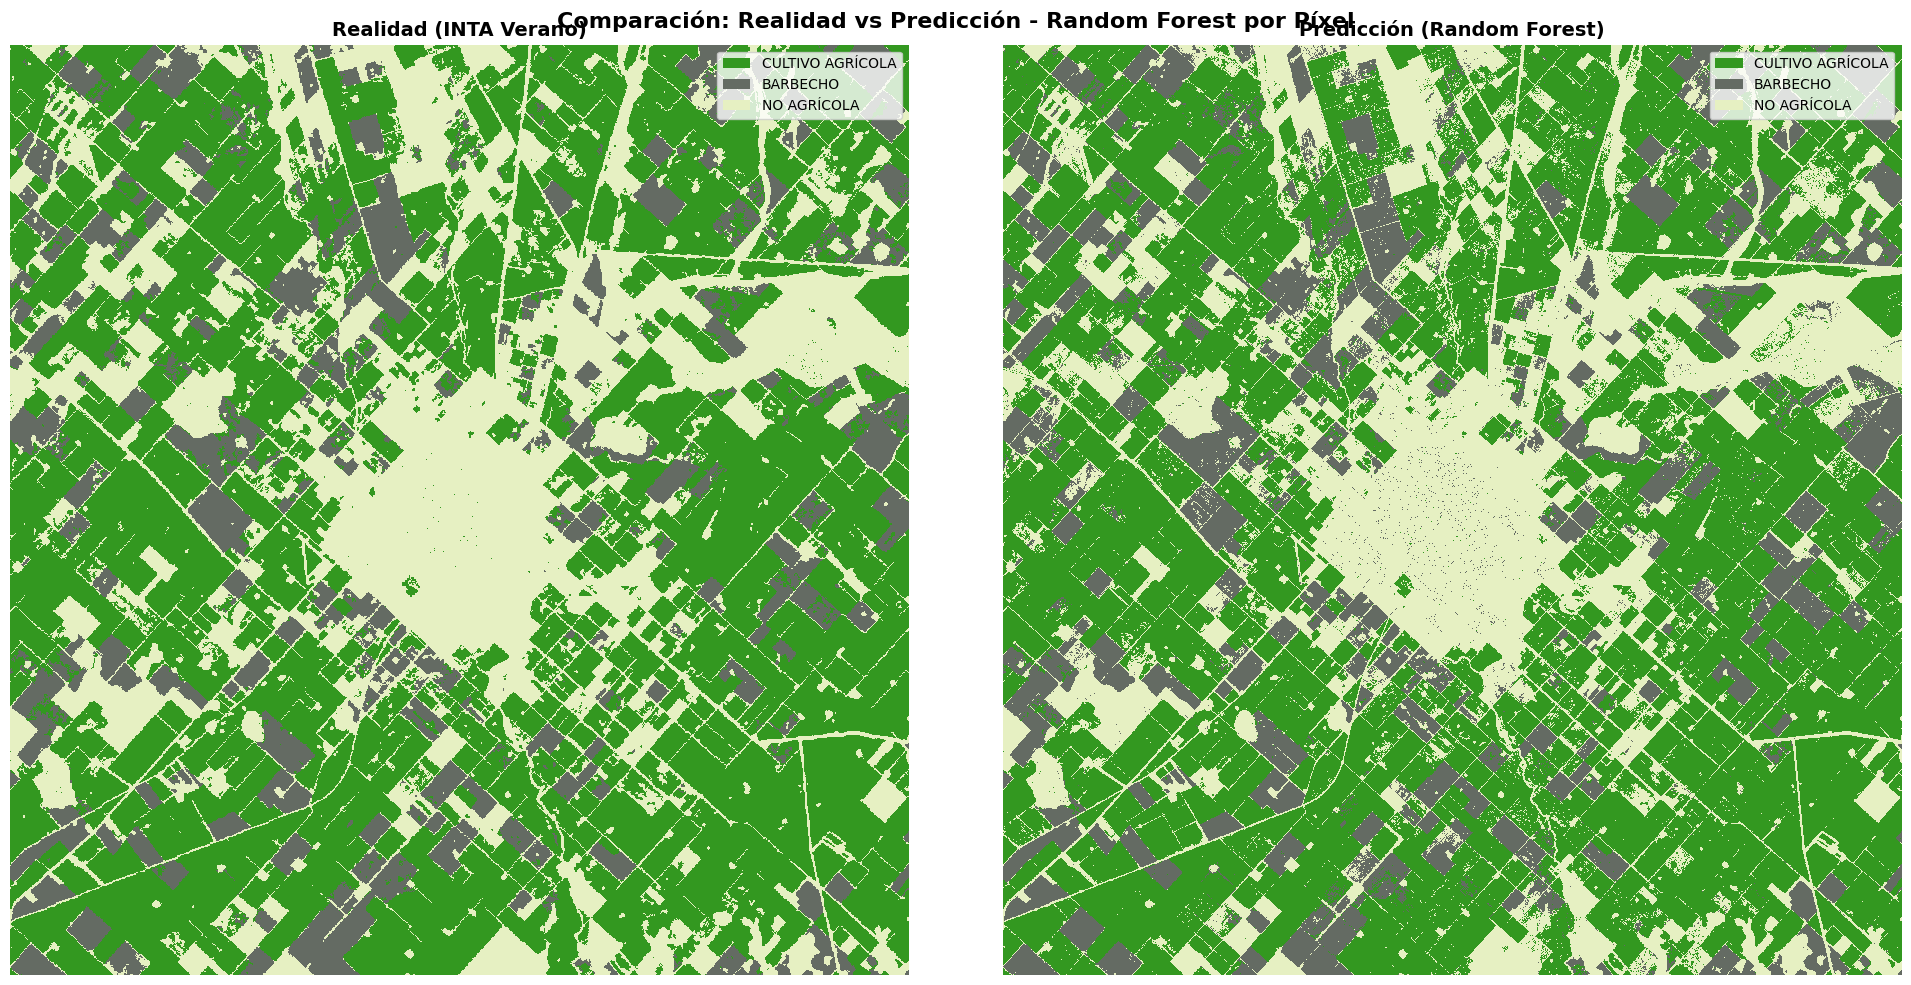


Accuracy espacial (sobre mapa completo): 0.9053 (90.53%)
Píxeles correctos: 7,337,234 de 8,104,712

Guardando mapa de predicción en: ..\data\proc\11_prediccion_rf_verano.tif
[OK] Mapa de predicción guardado


In [20]:
# Crear mapas de realidad vs predicción
print("=" * 80)
print("GENERANDO MAPAS DE COMPARACION")
print("=" * 80)

# Reconstruir mapas completos
mapa_realidad = np.full((height, width), -1, dtype=np.int32)
mapa_prediccion = np.full((height, width), -1, dtype=np.int32)

# Llenar con valores reales
mapa_realidad.flat[indices_clean] = y_clean

# Predecir para todos los píxeles válidos
print("\nPrediciendo para todos los píxeles válidos...")
tiempo_inicio_pred_all = time.time()
n_pixeles_total = len(X_clean)
print(f"  Total de píxeles a predecir: {n_pixeles_total:,}")

# Estimar tiempo basado en predicción anterior
if 'tiempo_pred' in locals() and len(X_test) > 0:
    tiempo_por_pixel = tiempo_pred / len(X_test)
    eta_pred_all = (tiempo_por_pixel * n_pixeles_total) / 60
    print(f"  Tiempo estimado: ~{eta_pred_all:.1f} minutos")

y_pred_all = rf_model.predict(X_clean)
tiempo_pred_all = time.time() - tiempo_inicio_pred_all
print(f"  [OK] Predicciones completadas en {tiempo_pred_all:.1f} segundos ({tiempo_pred_all/60:.1f} minutos)")

mapa_prediccion.flat[indices_clean] = y_pred_all

# Crear visualización
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Colores para las clases
colores_clases = {
    0: '#339820',  # Verde para CULTIVO AGRÍCOLA
    1: '#646b63',  # Gris para BARBECHO
    2: '#e6f0c2'   # Beige para NO AGRÍCOLA
}

from matplotlib.colors import ListedColormap
cmap_custom = ListedColormap([colores_clases[0], colores_clases[1], colores_clases[2]])

# Mapa de realidad
ax1 = axes[0]
im1 = ax1.imshow(mapa_realidad, cmap=cmap_custom, vmin=0, vmax=2, interpolation='nearest')
ax1.set_title('Realidad (INTA Verano)', fontsize=14, fontweight='bold')
ax1.axis('off')

# Agregar leyenda
from matplotlib.patches import Patch
handles = [Patch(facecolor=colores_clases[i], label=nombres_clases[i]) for i in range(3)]
ax1.legend(handles=handles, loc='upper right', fontsize=10)

# Mapa de predicción
ax2 = axes[1]
im2 = ax2.imshow(mapa_prediccion, cmap=cmap_custom, vmin=0, vmax=2, interpolation='nearest')
ax2.set_title('Predicción (Random Forest)', fontsize=14, fontweight='bold')
ax2.axis('off')
ax2.legend(handles=handles, loc='upper right', fontsize=10)

plt.suptitle('Comparación: Realidad vs Predicción - Random Forest por Píxel', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Calcular accuracy por región (solo donde hay datos válidos)
mask_comparacion = mapa_realidad >= 0
aciertos = (mapa_realidad[mask_comparacion] == mapa_prediccion[mask_comparacion]).sum()
total_comparacion = mask_comparacion.sum()
accuracy_espacial = aciertos / total_comparacion

print(f"\nAccuracy espacial (sobre mapa completo): {accuracy_espacial:.4f} ({accuracy_espacial*100:.2f}%)")
print(f"Píxeles correctos: {aciertos:,} de {total_comparacion:,}")

# Guardar mapa de predicción como raster
output_pred_path = os.path.join(DATA_PROC_DIR, "11_prediccion_rf_verano.tif")
print(f"\nGuardando mapa de predicción en: {output_pred_path}")

with rasterio.open(RASTER_PATH) as src:
    meta = src.meta.copy()
    meta.update({
        'count': 1,
        'dtype': 'int32',
        'nodata': -1
    })
    
    with rasterio.open(output_pred_path, 'w', **meta) as dst:
        dst.write(mapa_prediccion, 1)
        dst.set_band_description(1, 'Prediccion_RF_Verano')

print("[OK] Mapa de predicción guardado")
